# Analyzing COVID-19 statistics


In this notebook we demonstrate how **Prosto** toolkit can be used to analyze COVID-19 statistical data.

## What is Prosto toolkit

**Prosto** is a data processing toolkit radically changing how data is processed by heavily relying on *functions* and *operations with functions* as opposed to using only set operations in traditional approaches like map-reduce or join-groupby.

In **Prosto**, data is inferred using two categories of operations: producing new tables (mathematical sets) and producing new columns (mathematical functions). It is opposed to the classical approach where only set operations are used even if they are not very appropriate. In contrast to traditional approaches, **Prosto** derives new columns from already existing columns (although it also supports table operations).

## Goals and data schema

In this notebook, we build a simple workflow using three column operations: calculate, link and aggregate. It demonstrates how data can be processed by manipulating only columns without producing new tables. 

COVID-19 data is stored in two source tables:

* `all-states-history` table stores statistical data with such columns as `date`, `state`, `death`, `recovered`. Here is an example record: `<"2020-06-23","NE",249,11980>` which means that there were registered 249 deaths and 11980 recovered in Nebraska on June 23, 2020.
* `states` table stores a list of state names and abbreviations. Here is an example record `<NEBRASKA,NE>`

Our general goal is to aggregate statistical data in the `all-states-history` table for each state. More specifically, we want to find mean ratio of `death` to `recovered` for each state. 

A traditional approach would be to apply join for merging these two tables, then compute the ratio using calculated attributes into a new table, and finally apply groupy to aggregate data into a third table. Importantly, each of these operations will produce a new table and the final result is also a new independent table. In **Prosto**, our workflow will not produce new tables at all just because (conceptually) they are not needed. Instead, we solve the task by defining three new derived columns which simpler and more natural in comparision with the traditional approach. More specifically, we will apply the following three column operations:

* `calculate` column will compute the ratio between `death` and `recovered` by adding a new column to the existing `all-states-history` table
* `link` column will store references to rows in the `states` table and its result is also a new column in the `all-states-history` table
* `aggregate` column will use the previously computed link column for grouping and finding mean values of the calculated column by storing the results in a new column in the `states` table

The data and workflow structure are shown in the figure below:

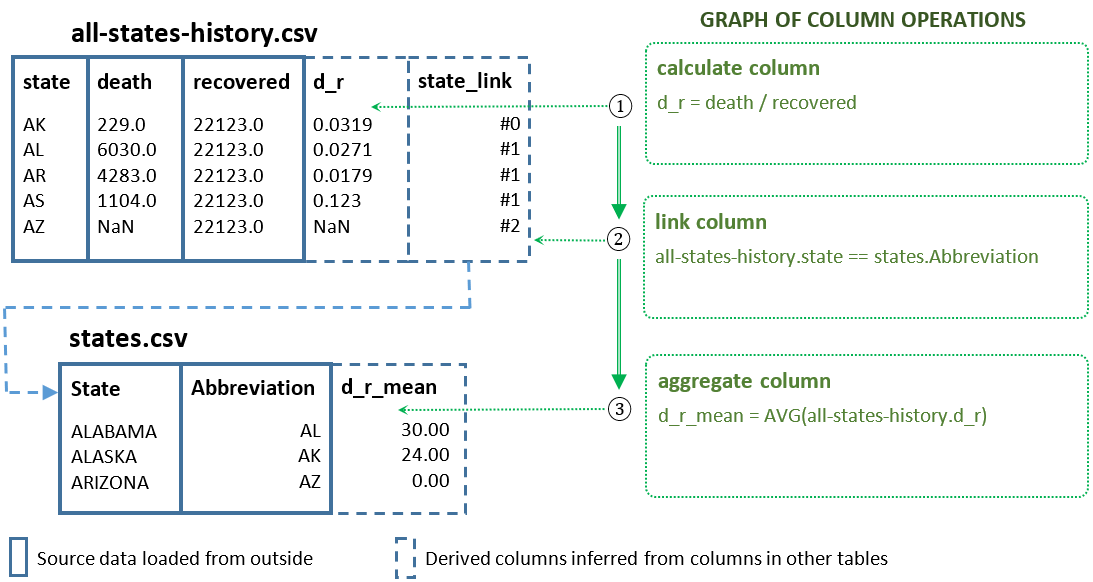

## Load data

We load data from two CSV files:

* `all-states-history.csv`
* `countries.csv`

The data is loaded into data frames which will be used later as sources for the **Prosto** workflow.

In [24]:
import pandas as pd  # Prosto relies on pandas
import prosto as pr  # Import Prosto toolkit

#
# Load data with history
#

# Data locations (only one will be used)
all_states_history_url = "https://covidtracking.com/data/download/all-states-history.csv"
all_states_history_file = "./data/all-states-history.csv"

# Load data either from remote (url) or local (file) location. Select only necessary columns
df_all_states_history = pd.read_csv(all_states_history_file, usecols=["date", "state", "death", "recovered"])

display(df_all_states_history.head())

#
# Load data with state names
#

# Data locations (only one will be used)
states_url = "https://raw.githubusercontent.com/cs109/2014_data/master/countries.csv"
states_file = "./data/states.csv"

# Load data either from remote (url) or local (file) location
df_states = pd.read_csv(states_file)

display(df_states.head())

,date,state,death,recovered
0,2021-01-15,AK,229.0,7165.0
1,2021-01-15,AL,6030.0,221961.0
2,2021-01-15,AR,4263.0,237729.0
3,2021-01-15,AS,0.0,NaN
4,2021-01-15,AZ,11040.0,89665.0


,State,Abbreviation
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ
3,ARKANSAS,AR
4,CALIFORNIA,CA


### Create a new workflow

Before we can process data in **Prosto**, it is necessary to create a **Prosto** workflow object. It will store definitins of all operations with data and also functionality for executing these operations. In general, workflow execution means that new data is derived (inferred) from existing or previsouly derived data. In **Prosto**, data typically processed in columns, that is, new columns are derived from existing columns.

In [25]:
# Create a workflow
prosto = pr.Prosto("COVID 19 Data Analysis")
# Element name is stored in the id field
print("Workflow name is: ´{}´".format(prosto.id))

Workflow name is: ´COVID 19 Data Analysis´


### Populate tables

Here we define two table objects. They are not derived from other tables using any operations. Instead, these are source tables which get their data from an external source - data frames in this case. If we change the data and re-run the workflow then the results will be re-computed according to the workflow operations.

In [26]:
# Populate the table with history
all_states_history = prosto.populate(
    table_name="all_states_history",  # Name in the workflow
    attributes=df_all_states_history.columns.tolist(),  # All attributes
    func=lambda **m: df_all_states_history,  # UDF to load data
    tables=[]  # Input tables (empty since no inputs for this operation)
)

# Populate the table with state names
states = prosto.populate(
    table_name="states",  # Name in the workflow
    attributes=["State", "Abbreviation"],  # All attributes
    func=lambda **m: df_states,  # UDF to load data
    tables=[]  # Input tables (empty since no inputs for this operation)
)

### Calculate column instead of a new table

Here we want to add a new calculated column defintion to the `all_states_history` table. This column (when evaluated) will compute the ratio of `death` attribute and `recovered` for each row. The desired computations are implemented in a user-defined function passed to the operation as lambda.

In [27]:
d_r = prosto.calculate(
    name="d_r",  # Column name in the workflow
    table="all_states_history",  # Table this column belongs to
    func=lambda x: x["death"] / x["recovered"],  # UDF to compute values
    columns=["death", "recovered"]  # Input column names
)

# We cannot display this derived column because it is not computed yet
prosto.run()
all_states_history.get_df()

,date,state,death,recovered,d_r
0,2021-01-15,AK,229.0,7165.0,0.0319609
1,2021-01-15,AL,6030.0,221961.0,0.0271669
2,2021-01-15,AR,4263.0,237729.0,0.0179322
3,2021-01-15,AS,0.0,NaN,None
4,2021-01-15,AZ,11040.0,89665.0,0.123125
...,...,...,...,...,...
17909,2020-01-17,WA,NaN,NaN,None
17910,2020-01-16,WA,NaN,NaN,None
17911,2020-01-15,WA,NaN,NaN,None
17912,2020-01-14,WA,NaN,NaN,None


### Link column instead of join

A link column stores row ids of some other table. These row ids are interpreted as references and hence it is possible to use this column to access the values in another table. The row ids are derived (computed) from using the provided criteria similar to join criteria.

A traditional way to use data from multiple tables is to apply join operation which produces a new table with the necessary data from several source tables. Prosto uses a different approach. Instead of deriving a new table, it attaches a new (link) column to an existing table which then provides access to the data in another table.

In this example, we want to link `all_states_history` to `states` by using state abbreviations which are present in the both tables. In other words, a statistical record will reference a state record which has the same abbreviation. After that, any column in the `states` table can be used from the `all_states_history` table using a sequence of link column names. For example,  `link_states::State` can be used to access state name.

In [28]:
link_states = prosto.link(
    # In contrast to other columns, a link column specifies its target table name
    name="link_states",  # Name in the workflow
    table="all_states_history",  # Table this column belongs to
    type="states",  # Table this column takes values from (function outputs)
    columns=["state"],  # Criterion: input columns in this table
    linked_columns=["Abbreviation"]  # Criterion: output columns in the type table
)

prosto.run()
all_states_history.get_df()

,date,state,death,recovered,d_r,link_states
0,2021-01-15,AK,229.0,7165.0,0.0319609,1
1,2021-01-15,AL,6030.0,221961.0,0.0271669,0
2,2021-01-15,AR,4263.0,237729.0,0.0179322,3
3,2021-01-15,AS,0.0,NaN,None,None
4,2021-01-15,AZ,11040.0,89665.0,0.123125,2
...,...,...,...,...,...,...
17909,2020-01-17,WA,NaN,NaN,None,46
17910,2020-01-16,WA,NaN,NaN,None,46
17911,2020-01-15,WA,NaN,NaN,None,46
17912,2020-01-14,WA,NaN,NaN,None,46


### Aggregate column instead of groupby

This column belongs to the `states` table and is treated as a new aggregated property computed for each state record. Yet, this property is computed using *groups* of records selected in another table - `all_states_history` in our case. More specifically, for each state, we want to select all statistical records which belong to it via the link column, and then find the mean of the `d_r` column.

Here we see one important difference of the Prosto approach. The aggregated column is defined directly in the `states` table and not in a newly generated table like in groupby or reduce. We do not join any tables and we do not produce a new table: the new column is defined directly where it has to be.

In [29]:
d_r_mean = prosto.aggregate(
    name="d_r_mean",  # Name in the workflow
    table="states",  # Table this column belongs to
    tables=["all_states_history"],  # Fact table with data to aggregate
    link="link_states",  # Grouping column from the fact to this table
    func="lambda x: x.mean()",  # UDF for aggregation
    columns=["d_r"],  # Colum of the fact table to aggregate
    model={}
)

prosto.run()
display(states.get_df().head())

,State,Abbreviation,d_r_mean
0,ALABAMA,AL,0.040470
1,ALASKA,AK,0.026810
2,ARIZONA,AZ,0.163518
3,ARKANSAS,AR,0.030728
4,CALIFORNIA,CA,0.000000


### Execute the workflow and explore the result

Above we provided only definitions. In order to really compute the result, we need to execute the workflow. This operation will build a topology (a graph of table and column operations) and then execute these operations according to their dependencies.

In [30]:
prosto.run()

display(states.get_df())

,State,Abbreviation,d_r_mean
0,ALABAMA,AL,0.040470
1,ALASKA,AK,0.026810
2,ARIZONA,AZ,0.163518
3,ARKANSAS,AR,0.030728
4,CALIFORNIA,CA,0.000000
5,COLORADO,CO,0.317048
6,CONNECTICUT,CT,0.523952
7,DELAWARE,DE,0.098682
8,FLORIDA,FL,0.000000
9,GEORGIA,GA,0.000000


### Summary

* In contrast to traditional set-oriented approaches, we did not use any set operations and no new tables were produced. Instead, we applied only column operations which derive new columns from existing data.
* All operations rely on user-defined functions in their definitions which specify programmatically how a new column value is computed from input values. The system then determines the sequence of application of these functions by implementing the necessary loops.
* Once a column has been defined, it can be re-used in many other operations without the need to embed it again where its results are needed. In particular, link columns are normally heavily used because they materialize the relationships between tables. In SQL, join needs to be specified and computed for each query even though it is the same. In our approach, a link is computed once and then becomes part of the model and can be used in other operations.
* The system automatically tracks all dependencies in the workflow and determines the sequence of execution of operations.